In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
num_epochs = 80
learning_rate = 0.001

# Image preprocessing modules
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])


In [2]:
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True,
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                            train=False,
                                            transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=100,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=100,
                                          shuffle=False)


100%|██████████| 170498071/170498071 [00:05<00:00, 29900959.70it/s]


Extracting ../../data/cifar-10-python.tar.gz to ../../data/


In [3]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3,
                     stride=stride, padding=1, bias=False)

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [5]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


In [6]:
model = ResNet(ResidualBlock, [2, 2, 2]).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [7]:
def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [8]:
total_step = len(train_loader)
curr_lr = learning_rate

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print('Epoch [{}/{}], Accuracy: {:.2f}%'.format(epoch+1, num_epochs, accuracy))

Epoch [1/80], Step [100/500] Loss: 1.5713
Epoch [1/80], Step [200/500] Loss: 1.3249
Epoch [1/80], Step [300/500] Loss: 1.0918
Epoch [1/80], Step [400/500] Loss: 1.2610
Epoch [1/80], Step [500/500] Loss: 1.1758
Epoch [1/80], Accuracy: 50.72%
Epoch [2/80], Step [100/500] Loss: 2.0002
Epoch [2/80], Step [200/500] Loss: 1.7694
Epoch [2/80], Step [300/500] Loss: 1.7044
Epoch [2/80], Step [400/500] Loss: 1.6385
Epoch [2/80], Step [500/500] Loss: 1.7956
Epoch [2/80], Accuracy: 39.43%
Epoch [3/80], Step [100/500] Loss: 1.4403
Epoch [3/80], Step [200/500] Loss: 1.6326
Epoch [3/80], Step [300/500] Loss: 1.4379
Epoch [3/80], Step [400/500] Loss: 1.5272
Epoch [3/80], Step [500/500] Loss: 1.3788
Epoch [3/80], Accuracy: 52.42%
Epoch [4/80], Step [100/500] Loss: 1.2230
Epoch [4/80], Step [200/500] Loss: 1.1605
Epoch [4/80], Step [300/500] Loss: 1.1676
Epoch [4/80], Step [400/500] Loss: 1.3524
Epoch [4/80], Step [500/500] Loss: 0.9268
Epoch [4/80], Accuracy: 59.67%
Epoch [5/80], Step [100/500] Loss: 1

In [9]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))


Accuracy of the model on the test images: 85.98 %


In [16]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=cb385292ff1239a9ace992421df1b158a6f37e56a901c8ba8b65b9432b0314c0
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [19]:
from torchviz import make_dot
model = ResNet(ResidualBlock, [2, 2, 2])

# Пример входных данных
x = torch.randn(1, 3, 32, 32)

# Визуализация модели
out = model(x)
dot = make_dot(out, params=dict(model.named_parameters()))
dot.render("resnet_model", format="png")

'resnet_model.png'

In [20]:
!pip install torchsummary

In [24]:
from torchsummary import summary

summary(model.to(device), input_size= (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,304
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]           2,304
       BatchNorm2d-8           [-1, 16, 32, 32]              32
              ReLU-9           [-1, 16, 32, 32]               0
    ResidualBlock-10           [-1, 16, 32, 32]               0
           Conv2d-11           [-1, 16, 32, 32]           2,304
      BatchNorm2d-12           [-1, 16, 32, 32]              32
             ReLU-13           [-1, 16, 32, 32]               0
           Conv2d-14           [-1, 16,

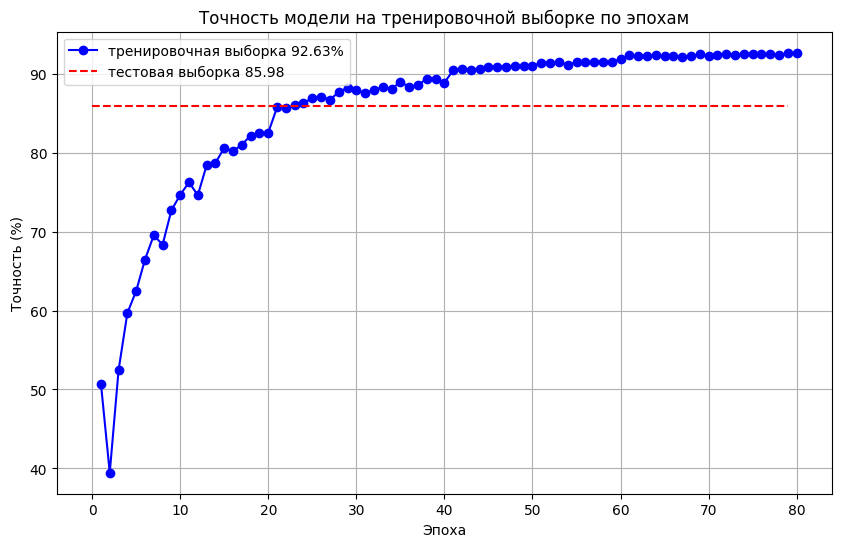

In [35]:
import matplotlib.pyplot as plt

# Данные для графика
epochs = list(range(1, 81))
accuracies = [
    50.72, 39.43, 52.42, 59.67, 62.48, 66.45, 69.54, 68.35, 72.70, 74.67,
    76.25, 74.62, 78.42, 78.72, 80.62, 80.21, 81.04, 82.19, 82.47, 82.57,
    85.75, 85.64, 86.02, 86.29, 86.95, 87.12, 86.72, 87.71, 88.27, 87.91,
    87.62, 87.98, 88.35, 88.13, 88.95, 88.40, 88.57, 89.42, 89.35, 88.89,
    90.47, 90.65, 90.47, 90.68, 90.84, 90.90, 90.92, 91.03, 91.05, 91.06,
    91.40, 91.39, 91.53, 91.18, 91.51, 91.51, 91.51, 91.56, 91.49, 91.90,
    92.35, 92.27, 92.26, 92.36, 92.24, 92.30, 92.18, 92.25, 92.50, 92.28,
    92.46, 92.51, 92.34, 92.54, 92.49, 92.56, 92.53, 92.38, 92.69, 92.63
]

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracies, marker='o', linestyle='-', color='b', label='тренировочная выборка 92.63%')
plt.plot([i for i in range(80)], [85.98 for _ in range(80)],  linestyle='--', color='r', label='тестовая выборка 85.98')
plt.title('Точность модели на тренировочной выборке по эпохам')
plt.legend(loc ='upper left')
plt.xlabel('Эпоха')
plt.ylabel('Точность (%)')
plt.grid(True)

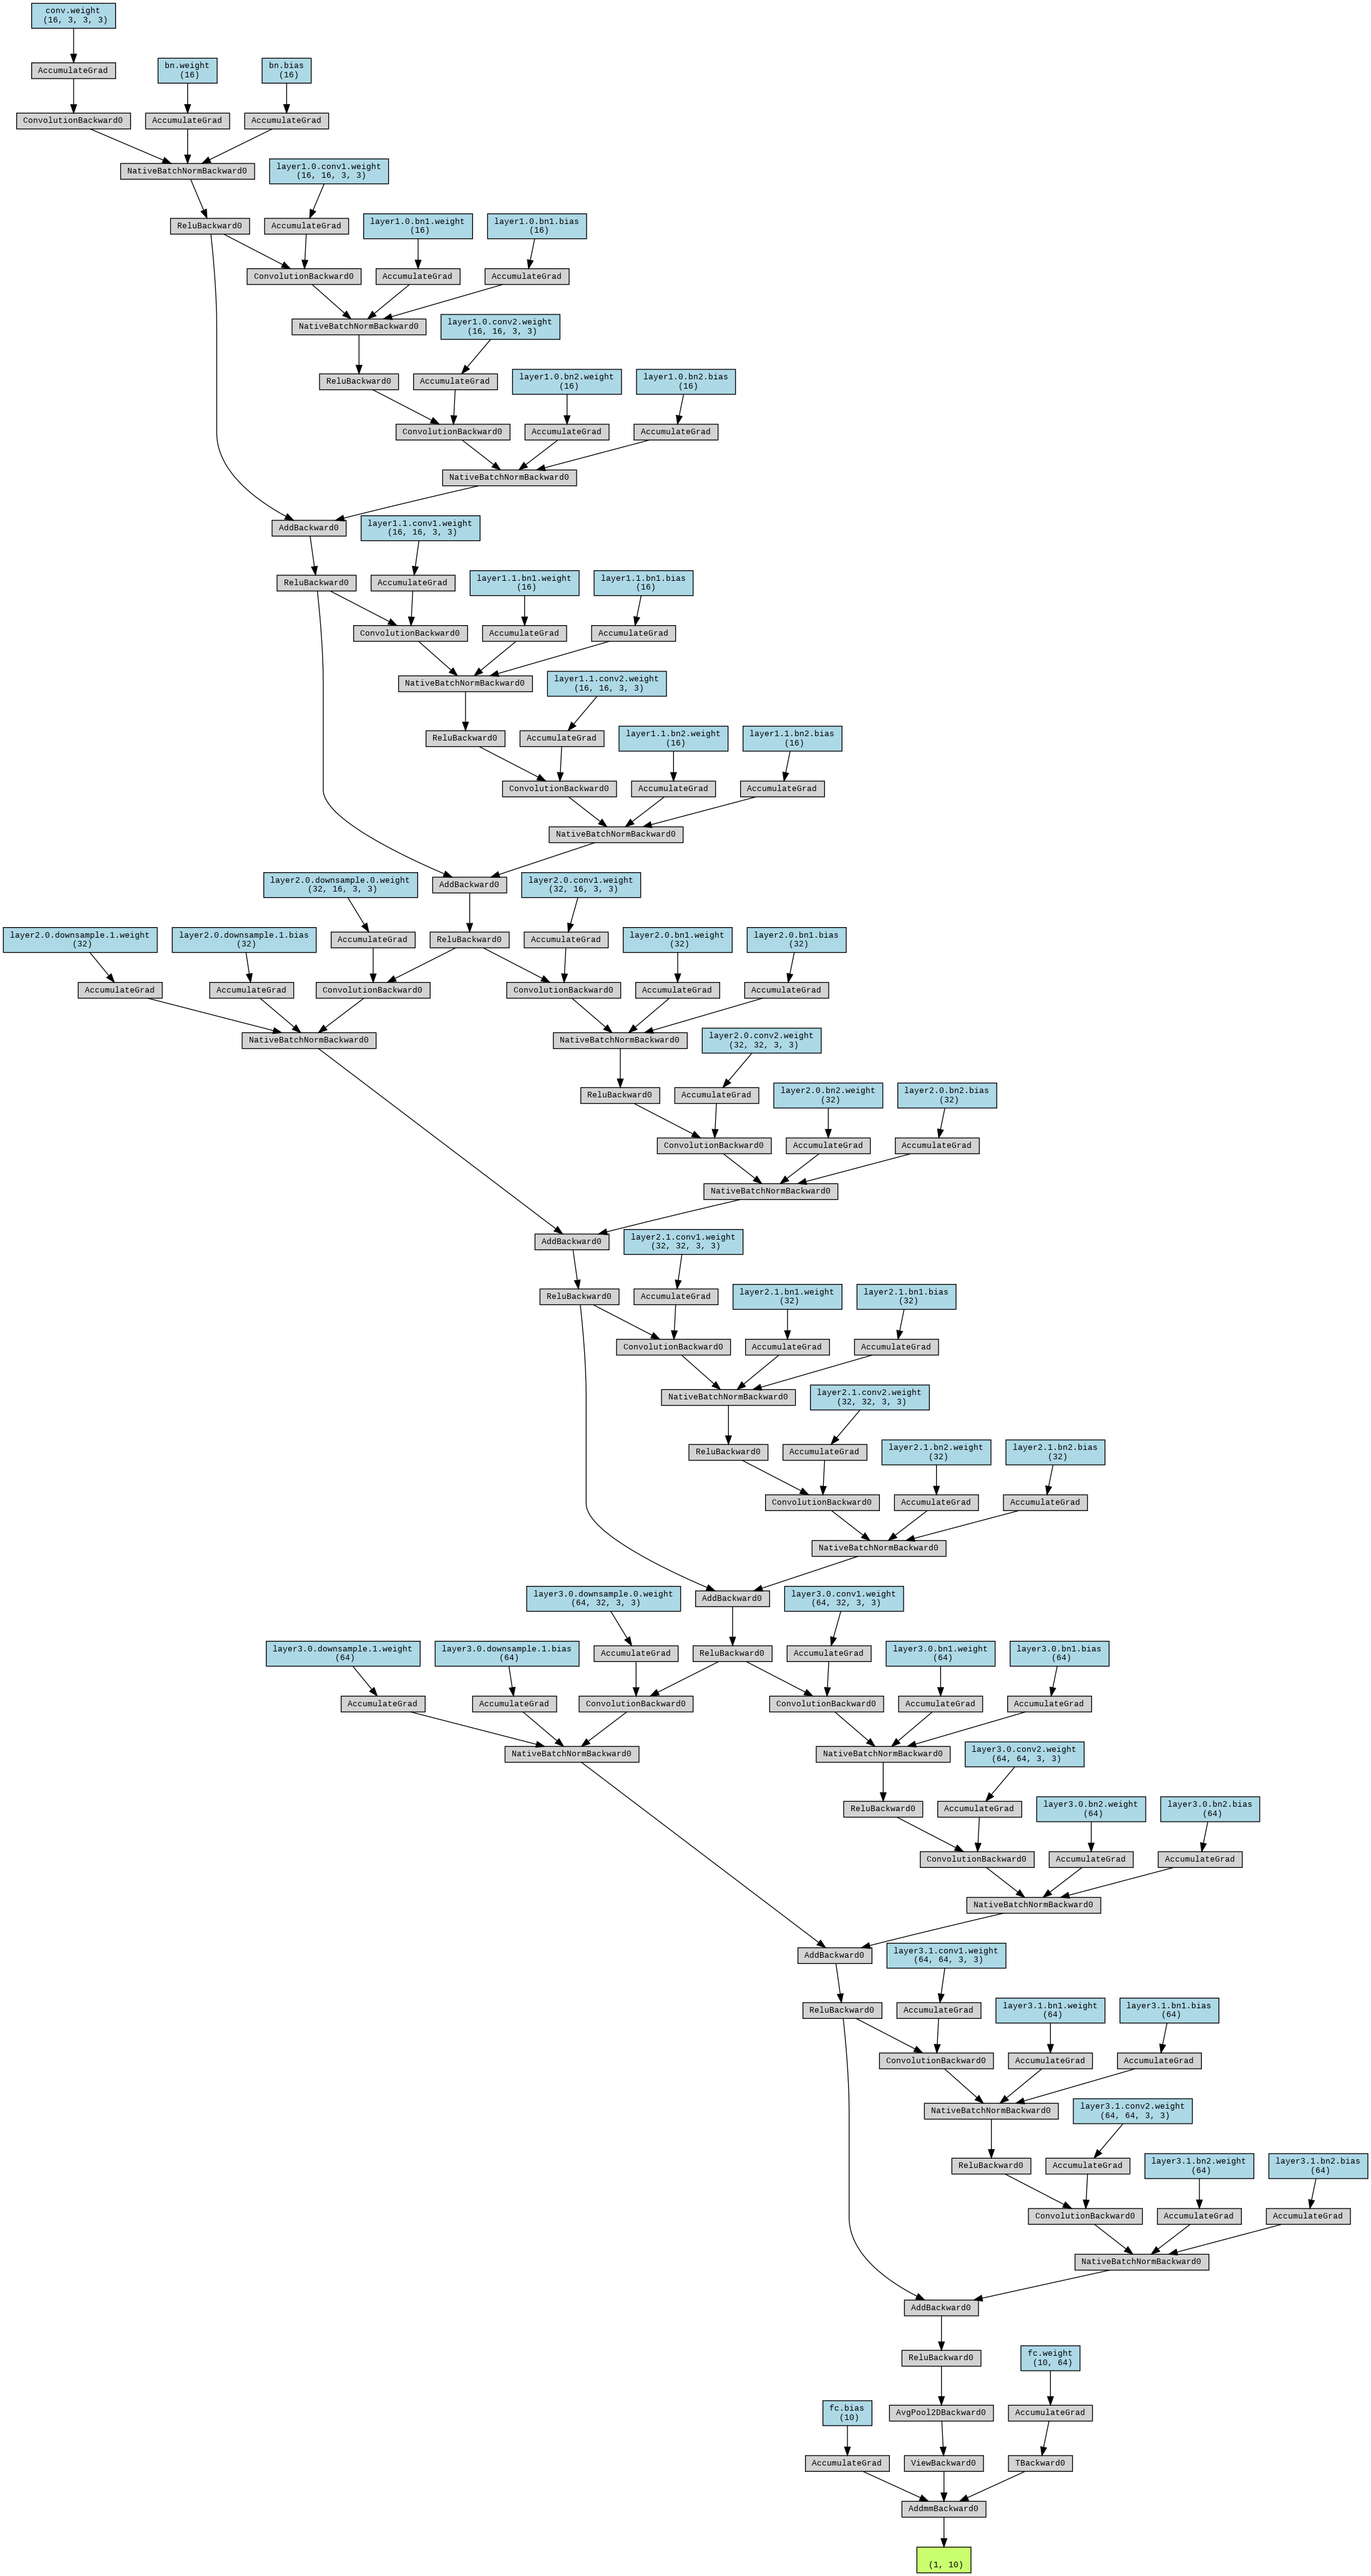

In [36]:
from IPython.display import Image

Image(filename='/content/resnet_model.png')